In [1]:
import xarray as xr
import matplotlib.pyplot as plt
# mpl
import matplotlib as mpl
import numpy as np
import pandas as pd

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
import os
import cmaps

In [2]:
df_oni = pd.read_excel('ONI.xlsx')
df_oni.drop(columns='time', inplace=True)
np_oni = df_oni.to_numpy()
np_oni = np_oni.flatten()

In [3]:
# Convert to dataframe pandas
df_oni = pd.DataFrame(np_oni, columns=['ONI'])
df_oni.index = pd.date_range('1950-01', '2023-12', freq='MS')
df_oni.index.name = 'time'
# Drop -99.99
df_oni = df_oni[df_oni.ONI != -99.90]

In [4]:
# Filter ONI to 1979-2022
df_sst = df_oni.loc['1979-01':'2023-04'].reset_index()

In [5]:
# df_sst = pd.read_excel(f'{os.path.expanduser("~")}/OneDrive/Climate_Extremes_DOC/DOC-Anomalies_SST.xlsx', sheet_name='ALL')
# df_sst.rename(columns={'Time': 'time'}, inplace=True)

In [6]:
ds_oni = df_sst.set_index('time')['ONI'].to_xarray()

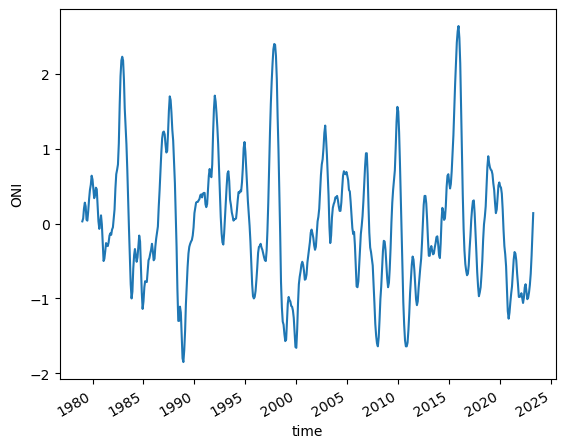

In [7]:
ds_oni.plot()

## Definindo El Nino e La Nina e Neutro

In [8]:
elnino = ds_oni.where(ds_oni >= 1)
lanina = ds_oni.where(ds_oni <= -1)
neutral = ds_oni.where(np.logical_and(ds_oni > -0.5, ds_oni < 0.5))

In [9]:
print('El Nino: ',elnino.count(dim='time').values)
print('Neutral: ',neutral.count(dim='time').values)
print('La Nina: ',lanina.count(dim='time').values)

counts=[elnino.count(dim='time').values,
        lanina.count(dim='time').values,
        neutral.count(dim='time').values]

El Nino:  60
Neutral:  255
La Nina:  58


In [10]:
# Open precipitation data
ds_precip = xr.open_dataset('precip.mon.mean.nc')

## Concatenar o tempo do banco de dados de precipitação com o tempo do banco de dados de temperatura da superfície do mar

In [11]:
ds_precip=ds_precip.sel(time=slice(ds_oni['time'][0],ds_oni['time'][-1]))
ds_precip

<xarray.Dataset>
Dimensions:    (lat: 72, lon: 144, time: 532, nv: 2)
Coordinates:
  * lat        (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon        (lon) float32 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2023-04-01
Dimensions without coordinates: nv
Data variables:
    time_bnds  (time, nv) datetime64[ns] ...
    lat_bnds   (lat, nv) float32 ...
    lon_bnds   (lon, nv) float32 ...
    precip     (time, lat, lon) float32 ...
Attributes: (12/18)
    Conventions:           CF-1.0
    curator:               Dr. Jian-Jian Wang\nESSIC, University of Maryland ...
    citation:              Adler, R.F., G.J. Huffman, A. Chang, R. Ferraro, P...
    title:                 GPCP Version 2.3 Combined Precipitation Dataset (F...
    platform:              NOAA POES (Polar Orbiting Environmental Satellites)
    source_obs:            CDR RSS SSMI/SSMIS Tbs over ocean \nCDR SSMI/SSMIS...
    ...                    ...
    source:                https://www.ncei.noaa.gov/data/global-precipitatio...
    source_documentation:  https://www.ncdc.noaa.gov/cdr/atmospheric/precipit...
    NCO:                   4.6.9
    history:               Generated at NOAA/ESRL PSD Sep 9 2016 based on dat...
    References:            http://www.psl.noaa.gov/data/gridded/data.gpcp.html
    data_comment:          Interim data covers 2023/04 through latest.

## Calcular as anomalias de precipitação

In [12]:
ds_climo = ds_precip.groupby('time.month').mean()
ds_anoms = ds_precip.groupby('time.month') - ds_climo
ds_anoms

<xarray.Dataset>
Dimensions:   (lat: 72, lon: 144, time: 532, nv: 2)
Coordinates:
  * lat       (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon       (lon) float32 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * time      (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2023-04-01
    month     (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 6 7 8 9 10 11 12 1 2 3 4
Dimensions without coordinates: nv
Data variables:
    lat_bnds  (time, lat, nv) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    lon_bnds  (time, lon, nv) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    precip    (time, lat, lon) float32 -0.02229 -0.03102 ... -0.2043 -0.2199

### Selecionar as datas de El Nino, La Nina e Neutro no banco de dados de precipitação

#### Calcular a composição de El Nino, La Nina e Neutro

In [13]:
elnino_precip = ds_anoms.sel(time=elnino.dropna(dim='time')['time']).mean(dim='time')
lanina_precip = ds_anoms.sel(time=lanina.dropna(dim='time')['time']).mean(dim='time')
neutral_precip = ds_anoms.sel(time=neutral.dropna(dim='time')['time']).mean(dim='time')

comp_precip=[elnino_precip,lanina_precip,neutral_precip]

In [14]:
# Paleta de cores
cmap_temp_ncl = cmaps.ncl_default
cmap_prec_ncl = cmaps.MPL_BrBG 

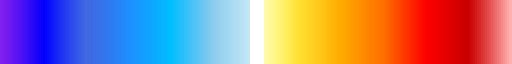

In [15]:
# Insert white color in cmap
cmap_temp_ncl = cmap_temp_ncl(np.arange(cmap_temp_ncl.N))
locs = [124, 125, 126, 127, 128, 129, 130]
for n in locs:
    cmap_temp_ncl[n] = np.array([1, 1, 1, 1]) # White -> 125, 126, 127, 128, 129
cmap_temp_ncl = mpl.colors.ListedColormap(cmap_temp_ncl)
cmap_temp_ncl

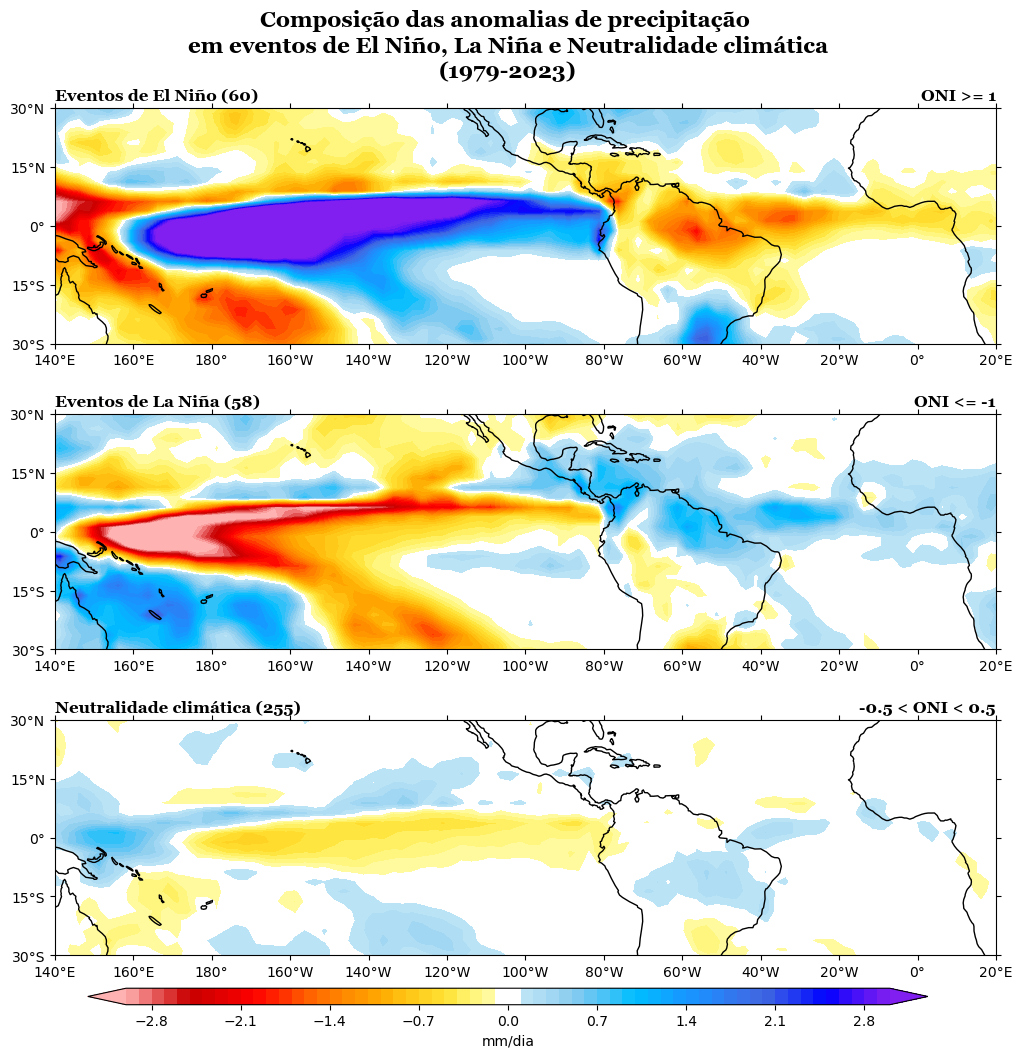

In [23]:
labels=['Eventos de El Niño','Eventos de La Niña', 'Neutralidade climática']
labels_ONI=['ONI >= 1','ONI <= -1', '-0.5 < ONI < 0.5']
clevs=np.arange(-3., 3.1, 0.1)

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=3,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=-140)},
                        figsize=(14,11), gridspec_kw={'hspace': 0.3})   # figsize=(8.5,11)

# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array
axs=axs.flatten()

#Loop over all of the seasons and plot
for i,enso in enumerate(comp_precip):
        
        # Select area extent
        axs[i].set_extent([140, 380, -30, 30], crs=ccrs.PlateCarree())

        # Select the season
        data=comp_precip[i]['precip']

        # Add the cyclic point
        data,lons=add_cyclic_point(data,coord=comp_precip[i]['lon'])

        # Contour plot
        cs=axs[i].contourf(lons,comp_precip[i]['lat'],data,clevs,
                          transform = ccrs.PlateCarree(),
                          cmap=cmap_temp_ncl.reversed(), extend='both')
        
        # Title each subplot with the name of the season
        axs[i].set_title(labels[i]+' ('+str(counts[i])+')', loc='left', fontsize=12, fontweight='bold', fontname='Georgia')
        axs[i].set_title(labels_ONI[i], loc='right', fontsize=12, fontweight='bold', fontname='Georgia')

        # Draw the coastines for each subplot
        axs[i].coastlines()

        # # Ticks X
        axs[i].set_xticks(
            np.arange(140, 380 + 20, 20), crs=ccrs.PlateCarree())
        axs[i].set_xticklabels(['140°E', '160°E', '180°', '160°W', '140°W', '120°W', '100°W', '80°W', '60°W', '40°W', '20°W', '0°', '20°E'])

        # # Ticks Y
        axs[i].set_yticks(np.arange(-30, 40, 15), crs=ccrs.PlateCarree())
        axs[i].set_yticklabels([
                '30°S', '15°S', '0°', '15°N', '30°N'
        ])

        # Ticks params
        axs[i].tick_params(axis='both', top=True, right=True)

# Add a colorbar axis at the bottom of the graph
# fig.add_axes([0.2, 0.135, 0.6, 0.015]) # [left, bottom, width, height]
cbar_ax = fig.add_axes([0.2, 0.065, 0.6, 0.015]) # [left, bottom, width, height]

# Draw the colorbar
cbar = fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='mm/dia')

# Add a big title at the top
plt.suptitle('Composição das anomalias de precipitação \nem eventos de El Niño, La Niña e Neutralidade climática\n(1979-2023)',
             fontsize=16,fontweight='bold',fontname='Georgia', y=0.97)

# Save figure
# fig.savefig('precip_composites.png', dpi=600, bbox_inches='tight', facecolor='w')